In [8]:
import os

# read text file into string
current_dir = os.getcwd()
file_path = f"{current_dir}/checkpoints/lisc/fixmatch_lisc_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/log.txt"
# file_path = f"{current_dir}/checkpoints/bccd/fixmatch_bccd_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/log.txt"
with open(file_path, "r") as f:
    logs = f.read()

logs

'Epoch 0, iter 1, Dice Sup Loss: 0.94711, Dice Unsup Loss: 0.99786, BCE Sup Loss: 0.73176, BCE UnSup Loss: 0.74018\nEpoch 0, iter 2, Dice Sup Loss: 0.93948, Dice Unsup Loss: 1.0, BCE Sup Loss: 0.55653, BCE UnSup Loss: 0.56667\nEpoch 0, iter 3, Dice Sup Loss: 0.94655, Dice Unsup Loss: 1.0, BCE Sup Loss: 0.44042, BCE UnSup Loss: 0.4394\nEpoch 0, iter 4, Dice Sup Loss: 0.93027, Dice Unsup Loss: 1.0, BCE Sup Loss: 0.36297, BCE UnSup Loss: 0.3666\nEpoch 0, iter 5, Dice Sup Loss: 0.8909, Dice Unsup Loss: 1.0, BCE Sup Loss: 0.30438, BCE UnSup Loss: 0.29826\nEpoch 0, iter 6, Dice Sup Loss: 0.89814, Dice Unsup Loss: 1.0, BCE Sup Loss: 0.25397, BCE UnSup Loss: 0.2489\nEpoch 0, iter 7, Dice Sup Loss: 0.90035, Dice Unsup Loss: 1.0, BCE Sup Loss: 0.21655, BCE UnSup Loss: 0.20568\nEpoch 0, iter 8, Dice Sup Loss: 0.87552, Dice Unsup Loss: 1.0, BCE Sup Loss: 0.19104, BCE UnSup Loss: 0.1857\nEpoch 0, iter 9, Dice Sup Loss: 0.86997, Dice Unsup Loss: 1.0, BCE Sup Loss: 0.16884, BCE UnSup Loss: 0.14856\nE

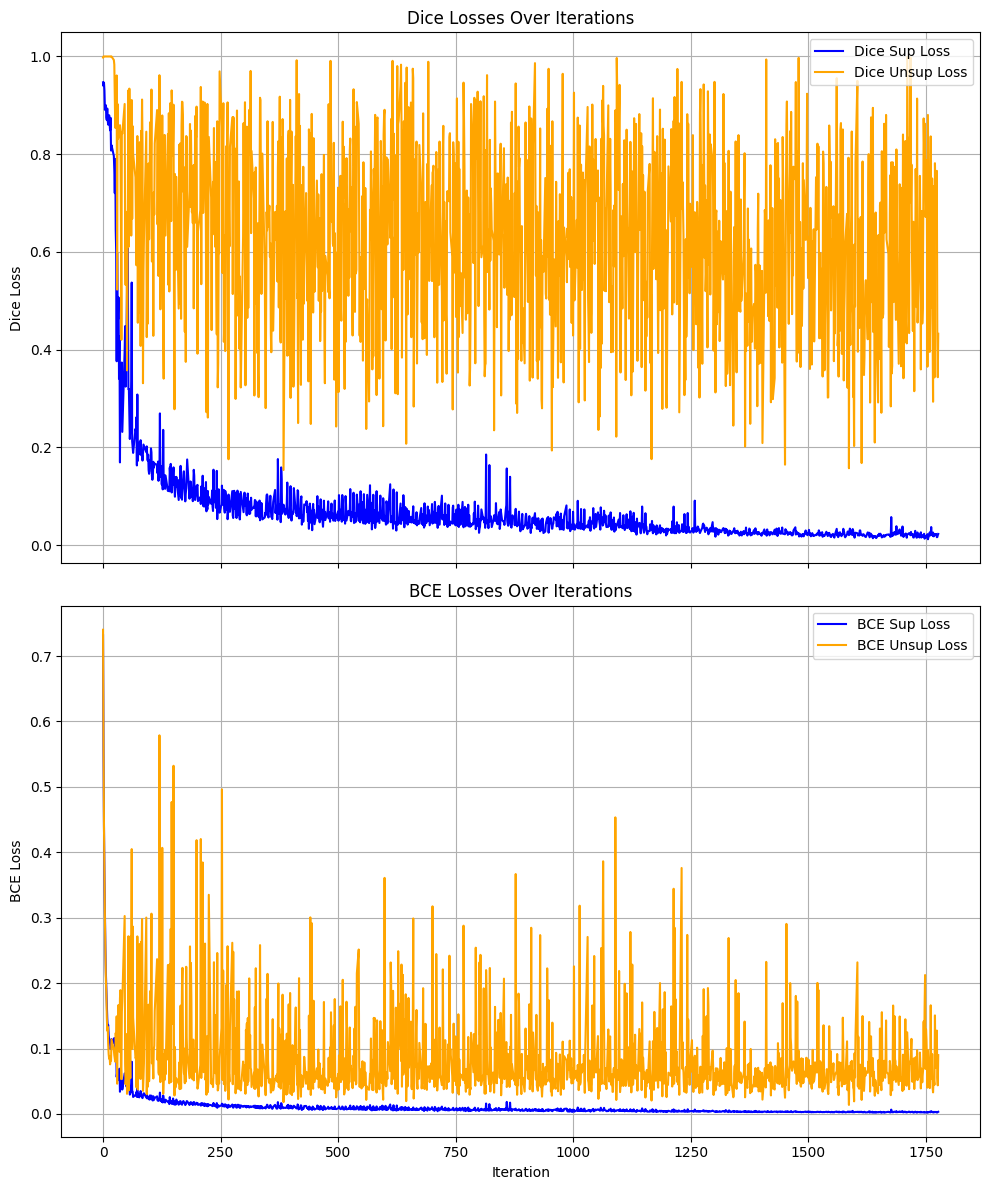

In [9]:
import re
import matplotlib.pyplot as plt

# Compile regular expression to parse the relevant lines
pattern = re.compile(
    r"Epoch (\d+), iter (\d+), Dice Sup Loss: ([\d.]+), Dice Unsup Loss: ([\d.]+), BCE Sup Loss: ([\d.]+), BCE UnSup Loss: ([\d.]+)"
)

# Initialize lists to store the extracted values
iters = []
dice_sup_losses = []
dice_unsup_losses = []
bce_sup_losses = []
bce_unsup_losses = []

# Parse the logs
for epoch, line in enumerate(logs.strip().split("\n")):
    match = pattern.match(line)
    if match:
        dice_sup_loss = float(match.group(3))
        dice_unsup_loss = float(match.group(4))
        bce_sup_loss = float(match.group(5))
        bce_unsup_loss = float(match.group(6))

        # Append values to the lists
        iters.append(epoch)
        dice_sup_losses.append(dice_sup_loss)
        dice_unsup_losses.append(dice_unsup_loss)
        bce_sup_losses.append(bce_sup_loss)
        bce_unsup_losses.append(bce_unsup_loss)


# Function to plot the data in subplots
def plot_losses_subplots(iters, dice_losses, bce_losses):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

    # Plot Dice losses
    ax1.plot(iters, dice_losses["Dice Sup Loss"], label="Dice Sup Loss", color="blue")
    ax1.plot(
        iters, dice_losses["Dice Unsup Loss"], label="Dice Unsup Loss", color="orange"
    )
    ax1.set_ylabel("Dice Loss")
    ax1.set_title("Dice Losses Over Iterations")
    ax1.legend()
    ax1.grid(True)

    # Plot BCE losses
    ax2.plot(iters, bce_losses["BCE Sup Loss"], label="BCE Sup Loss", color="blue")
    ax2.plot(
        iters, bce_losses["BCE Unsup Loss"], label="BCE Unsup Loss", color="orange"
    )
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("BCE Loss")
    ax2.set_title("BCE Losses Over Iterations")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Prepare loss values for plotting
dice_losses = {
    "Dice Sup Loss": dice_sup_losses,
    "Dice Unsup Loss": dice_unsup_losses,
}

bce_losses = {
    "BCE Sup Loss": bce_sup_losses,
    "BCE Unsup Loss": bce_unsup_losses,
}

# Plot the data
plot_losses_subplots(iters, dice_losses, bce_losses)

# Plot inferences

In [10]:
import yaml
from Datasets.create_dataset import get_dataset, SkinDataset2, StrongWeakAugment2
from Utils.pieces import DotDict

config = yaml.load(open("Configs/multi_train_local.yml"), Loader=yaml.FullLoader)
config["fold"] = 1
config["data"]["supervised_ratio"] = 0.25
# update dataset
ls_update_keys = [
    "name",
    "save_folder",
    "test_folder",
    "train_folder",
    "val_folder",
]
for key in ls_update_keys:
    config["data"][key] = config["data"][key].replace("isic2018", "lisc")

config = DotDict(config)
dataset = get_dataset(
    config,
    img_size=config["data"]["img_size"],
    supervised_ratio=config["data"]["supervised_ratio"],
    train_aug=config["data"]["train_aug"],
    k=config["fold"],
    lb_dataset=SkinDataset2,
    ulb_dataset=StrongWeakAugment2,
)

Train Data: 10_baso.npy - 200
Labeled Data: 12_neut.npy - 50
Unlabeled Data: 10_baso.npy - 150
Val Data: 11_baso.npy - 50


SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


/home/m12gbs1/miniconda3/envs/ssl-in-medical-image-segmentation/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_722979/2958667777.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be l

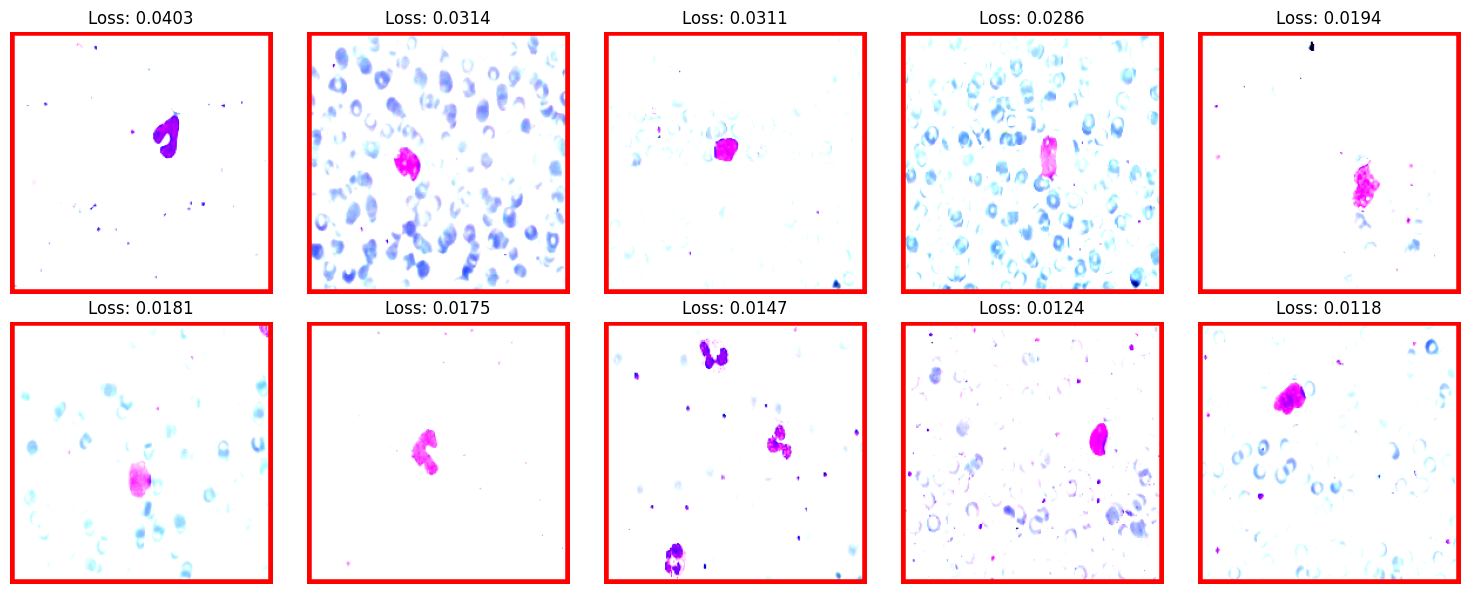

In [11]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from Models.Transformer.SwinUnet import SwinUnet
from Utils.losses import dice_loss


# Assuming your model is a custom ConvNet
def load_model(model_path):
    model = model = SwinUnet(img_size=224)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


# Assuming a loss function (e.g., BCEWithLogitsLoss)
def calculate_loss(output, target):
    criterion = nn.BCEWithLogitsLoss()  # or another loss function
    loss = criterion(output, target)
    return loss.item()


# Function to plot top bad inferences
def plot_top_bad_inferences(bad_inferences, num_images=10, cols=5):
    rows = num_images // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    for i, (image, seg, loss) in enumerate(bad_inferences[:num_images]):
        ax = axes[i // cols, i % cols]

        # plot the original image
        image = image.reshape(3, 224, 224).permute(1, 2, 0).cpu().numpy()

        # Apply threshold to get binary mask
        seg = torch.sigmoid(seg).squeeze().detach().cpu().numpy()
        binary_mask = (seg > 0.5).astype(np.uint8)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(
            binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Draw contours in red
        contour_image = cv2.drawContours(image.copy(), contours, -1, (255, 0, 0), 5)

        ax.imshow(contour_image)
        ax.axis("off")
        ax.set_title(f"Loss: {loss:.4f}")

    plt.tight_layout()
    plt.show()


model_path = "checkpoints/lisc/fixmatch_lisc_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/best.pth"
model = load_model(model_path)

test_loader = torch.utils.data.DataLoader(
    dataset["val_dataset"],
    batch_size=1,
    shuffle=False,
    num_workers=config.test.num_workers,
    pin_memory=True,
    drop_last=False,
)
criterion = [nn.BCELoss(), dice_loss]

bad_inferences = []
for batch_id, batch in enumerate(test_loader):
    img = batch["image"].cpu().float()
    label = batch["label"].cpu().float()

    batch_len = img.shape[0]

    with torch.no_grad():

        output = model(img)

        output = torch.sigmoid(output)

        # calculate loss
        assert output.shape == label.shape
        losses = []
        for function in criterion:
            losses.append(function(output, label))

        bad_inferences.append((img, output, losses[0]))

# Sort by loss in descending order
bad_inferences.sort(key=lambda x: x[2], reverse=True)

# Plot top 10 bad inferences
plot_top_bad_inferences(bad_inferences)

# Test results

In [13]:
import re
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
result_files = glob("checkpoints/*/*/*/test_results.txt")
result_files

['checkpoints/lisc/cps_lisc_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/test_results.txt',
 'checkpoints/lisc/train_sup_lisc_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/test_results.txt',
 'checkpoints/lisc/fixmatch_lisc_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/test_results.txt',
 'checkpoints/lisc/ccvc_lisc_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/test_results.txt',
 'checkpoints/lisc/cct_lisc_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/test_results.txt',
 'checkpoints/lisc/unimatch_lisc_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/test_results.txt',
 'checkpoints/bccd/train_sup_bccd_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/test_results.txt',
 'checkpoints/bccd/cps_bccd_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/test_results.txt',
 'checkpoints/bccd/cct_bccd_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/test_r

In [18]:
# Initialize an empty list to store the results
results_list = []

# Regular expression pattern to extract numerical values from result files
pattern = re.compile(r"loss:\s*([\d.]+),\s*Dice_score\s*([\d.]+),\s*IOU:\s*([\d.]+)")


def extract_parameters(file_path):
    """Extracts parameters from the file path."""
    parts = file_path.split("/")
    method_info = parts[2].split("_")
    dataset = parts[1]
    method = method_info[0] if dataset else "_".join(method_info[:2])
    conf_thresh = method_info[-1]
    seed = method_info[-2]
    fold = parts[-2][-1]  # Extract fold number
    return dataset, method, conf_thresh, seed, fold


# Process each result file
for file in result_files:
    with open(file, "r") as f:
        content = f.read()
        match = pattern.search(content)
        if match:
            loss, dice_score, iou = match.groups()
            dataset, method, conf_thresh, seed, fold = extract_parameters(file)
            results_list.append(
                [
                    dataset,
                    method,
                    float(conf_thresh),
                    int(seed),
                    int(fold),
                    8,
                    float(loss),
                    float(iou),
                    float(dice_score),
                ]
            )

# Convert the list to a DataFrame
results_df = pd.DataFrame(
    results_list,
    columns=[
        "dataset",
        "method",
        "Threshold",
        "Seed",
        "Folds",
        "Batch",
        "Loss",
        "IoU",
        "Dice",
    ],
)
print(results_df)

   dataset    method  Threshold  Seed  Folds  Batch      Loss       IoU  \
0     lisc       cps       0.25     1      1      8  0.101077  0.811780   
1     lisc     train       0.25     1      1      8  0.104603  0.799113   
2     lisc  fixmatch       0.25     1      1      8  0.096186  0.812714   
3     lisc      ccvc       0.25     1      1      8  0.098779  0.807408   
4     lisc       cct       0.25     1      1      8  0.105448  0.807220   
5     lisc  unimatch       0.25     1      1      8  0.108256  0.798919   
6     bccd     train       0.25     1      1      8  0.996889  0.106509   
7     bccd       cps       0.25     1      1      8  0.994984  0.106710   
8     bccd       cct       0.25     1      1      8  0.988794  0.106482   
9     bccd      ccvc       0.25     1      1      8  0.988684  0.106700   
10    bccd  fixmatch       0.25     1      1      8  0.986515  0.106802   
11    bccd  unimatch       0.25     1      1      8  0.997718  0.109582   

        Dice  
0   0.895

In [19]:
results_df.to_csv("results.csv", index=False)

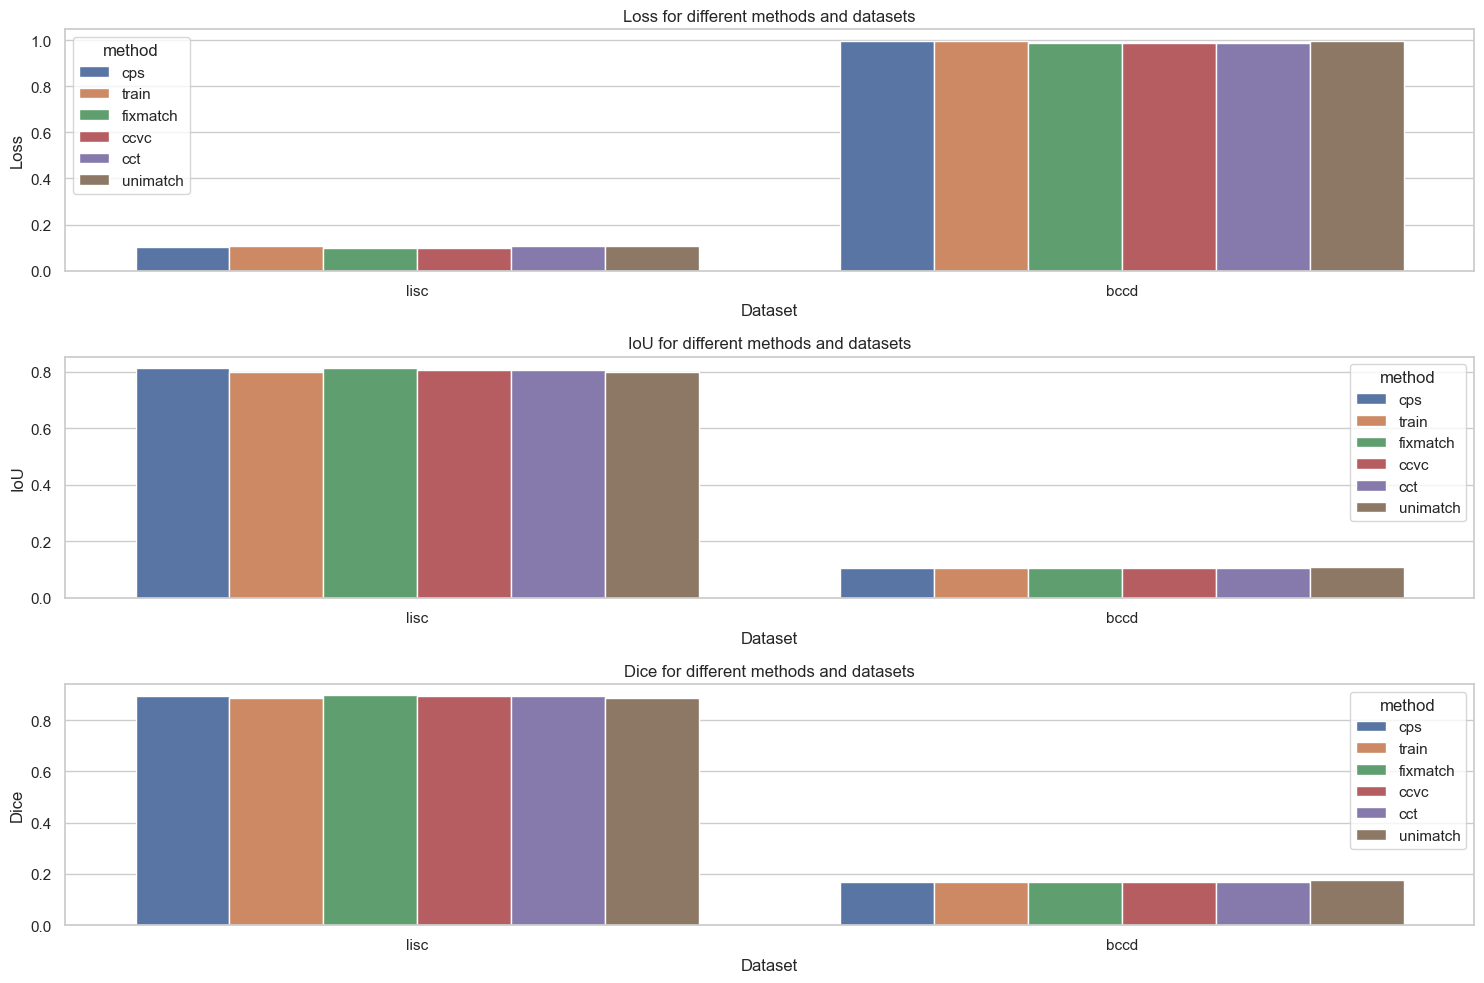

In [20]:
# Plotting settings
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Create plots for each metric
metrics = ["Loss", "IoU", "Dice"]
for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i + 1)
    sns.barplot(x="dataset", y=metric, hue="method", data=results_df)
    plt.title(f"{metric} for different methods and datasets")
    plt.xlabel("Dataset")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()